# show relation between DMS prediction and learning curve

# tRNA(CCU anticodon)

In [1]:
%cd /Users/sumishunsuke/Desktop/RNA/genzyme

import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/sumishunsuke/Desktop/RNA/genzyme


In [ ]:
random_seeds = range(10)
for i, seed in enumerate(random_seeds):
    cmd = f"""
    python ./scripts/train_CMVAE.py \
    --data_dir ./datasets/ForDMSdata/RF00005_CCU \
    --X_train RF00005_unique_CCUanticodon_notrunc_traceback_onehot_cm_train.h5 \
    --w_train RF00005_unique_CCUanticodon_notrunc_traceback_onehot_cm_train_weight_threshold0p2.h5 \
    --X_valid RF00005_unique_CCUanticodon_notrunc_traceback_onehot_cm_valid.h5 \
    --w_valid RF00005_unique_CCUanticodon_notrunc_traceback_onehot_cm_valid_weight_threshold0p2.h5 \
    --beta 0.016 \
    --log \
    --log_dir ./outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae  \
    --use_anneal \
    --use_early_stopping \
    --save_ckpt \
    --ckpt_iter 3 \
    --random_seed {str(seed)} \
    --suffix _trial{str(i).zfill(2)}
    """
    # res = subprocess.run(cmd, shell = True, capture_output = True)
    print(f"trial {str(i).zfill(2)}, done")
    print(res.stderr.decode())

# pred DMS 

In [11]:
ckpts = !ls -t ./outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/*.pt
ckpts_dict = {f"trial{str(i).zfill(2)}":{} for i in range(10)}
for ckpt in ckpts:
    ckpt_name = ckpt.split("/")[-1].split("_")[-1].replace(".pt", "")
    epoch = int(ckpt.split("/")[-1].split("_")[-2].replace("epoch", ""))
    ckpts_dict[ckpt_name][epoch] = ckpt

ckpts_dict["trial00"]

{49: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch49_trial00.pt',
 48: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch48_trial00.pt',
 45: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch45_trial00.pt',
 42: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch42_trial00.pt',
 39: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch39_trial00.pt',
 36: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch36_trial00.pt',
 33: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch33_trial00.pt',
 30: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch30_trial00.pt',
 27: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch27_trial00.pt',
 24: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch24_trial00.pt',
 21: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch21_trial00.pt',
 18: './outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/model_epoch18_trial00.pt',
 15:

In [ ]:
dms_trsp = "./datasets/ForDMSdata/RF00005_CCU/activity/Li2016_notrunc_traceback_onehot_cm.h5"


cmd = f"""
ls -t ./outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/*.pt | \
xargs -P7 -I @ python ./scripts/pred_activity_with_CMVAE.py \
--in_trsp {dms_trsp} \
--ckpt @ \
--model_config ./outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/config_trial00.yaml \
--n_samples 5 \
"""


res = subprocess.run(cmd, shell = True, capture_output = True)
print(res.stderr.decode())

# comparison between loss and dms pred

In [90]:
def load_dms_results(file):
    eve = []
    with open(file, "r") as f: 
        for line in f:
            if not line.startswith("#"):
                eve.append(float(line))

    return eve


def get_dict_pred():
    d = {}
    for i in range(10):
        d_trial = {}
        pred_files_trial = !ls -t ../../outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/*trial{str(i).zfill(2)}*.txt
        # print(pred_files_trial)
        for pred_file in pred_files_trial:
            # print(pred_file)
            epoch = int(pred_file.split("/")[-1].split("_")[1].replace("epoch", ""))
            
            d_trial[epoch] = load_dms_results(pred_file)
        d[i] = d_trial
    return d


d = get_dict_pred()
d[1][3]


In [102]:
d_trial = {}
for i in range(10):

    df_loss = pd.read_csv(f"../../outputs/ForDMSdata/RF00005_CCU/timecourse_cmvae/log_valid_trial{str(i).zfill(2)}.csv")
    df_loss.head()
    df_loss["Spearman's ρ"]= [np.nan for i in df_loss.index]
    for idx in df_loss.index:
        try:
            df_loss["Spearman's ρ"][idx] = d_spearmanr[i][idx]
        except:
            pass

    d_trial[i] = df_loss

d_trial[1]

,loss_valid,kl_valid,elbo_valid,Spearman's ρ
0,27.845746,0.000251,27.845778,NaN
1,26.578389,0.000181,26.578412,NaN
2,26.000580,0.000248,26.000612,NaN
3,25.674200,0.000536,25.674268,-0.470647
4,25.327111,0.000004,25.327112,NaN
...,...,...,...,...
64,24.076894,0.000062,24.076902,NaN
65,24.040079,0.000000,24.040079,NaN
66,24.074296,0.000004,24.074296,-0.544262
67,24.085179,0.000005,24.085179,NaN


In [94]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

Text(0.5, 1.0, "tRNA (Li et al., 2016), trial 00, Spearman's ρ = 0.64")

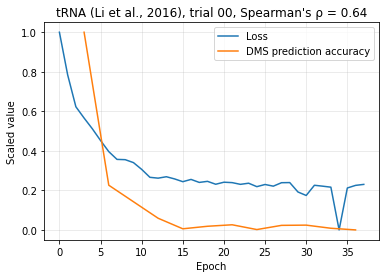

In [133]:
plt.plot(
    df_loss["elbo_valid"].index,
    normalize(df_loss["elbo_valid"]), label = "Loss")

plt.plot(
    df_loss["Spearman's ρ"].dropna(axis = 0).index,
    normalize(df_loss["Spearman's ρ"].dropna(axis = 0)),
    label = "DMS prediction accuracy")
 

plt.grid(alpha = 0.3)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Scaled value")

corr, p = spearmanr(df_loss.dropna(axis = 0)["elbo_valid"], df_loss.dropna(axis = 0)["Spearman's ρ"])
plt.title("tRNA (Li et al., 2016), trial 00, Spearman's ρ = {:.2f}".format(corr))


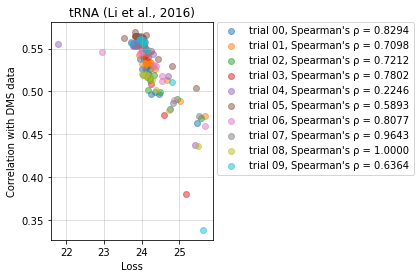

In [136]:
for i in range(10):
    df_tmp = d_trial[i].dropna(axis = 0)
    corr, p = spearmanr(df_tmp["elbo_valid"], df_tmp["Spearman's ρ"])

    plt.scatter(
        df_tmp["elbo_valid"],
        df_tmp["Spearman's ρ"].abs(), alpha = 0.5, label = f"trial {str(i).zfill(2)}, Spearman's ρ = {corr:.4f}")
plt.grid(alpha = 0.5)
plt.legend(loc = (1.03, 0.3))
# plt.legend(fontsize = 8)
plt.xlabel("Loss")
plt.ylabel("Correlation with DMS data")
plt.title("tRNA (Li et al., 2016)")
plt.subplots_adjust(right = 0.5)

# plt.savefig("../../outputs/figures/suppfig_dmspred_and_loss_tRNA.pdf", transparent = True)